In [29]:
# Ni Utils
from nilearn.datasets import fetch_spm_auditory
from nilearn.plotting import plot_anat, plot_img, plot_stat_map
from nilearn.image import concat_imgs, mean_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix

# Sci Utils
from scipy.stats import gamma

# Plotting Utils
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

# Table Utils
import pandas as pd

import numpy as np

In [2]:
subject_data = fetch_spm_auditory()

In [3]:
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)
events = pd.read_table(subject_data["events"])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


In [11]:
# (x,y,z, signal)
all_data = fmri_img.get_fdata()
print(all_data.shape)
print(all_data[0][0][0][0])

(64, 64, 64, 96)
42.0


In [22]:
fmri_glm = FirstLevelModel(
    t_r=7,                  # is the time of repetition of acquisitions
    noise_model="ar1",      # specifies the noise covariance model: lag-1 dependence
    standardize=False,      # we don't rescale the time series to mean 0, variance 1
    hrf_model="spm",        # we rely on the SPM (Statistical Parametric Mapping) model
    drift_model="cosine",   # we model the signal drifts as slow oscillating time functions
    high_pass=0.01,         # defines the cutoff frequency
)

fmri_glm = fmri_glm.fit(fmri_img, events)
X = fmri_glm.design_matrices_[0]

In [23]:
X.shape # 96 data points comprised of 16 sessions (active, rest, drifts ....., constant)

(96, 16)

In [24]:
Y = fmri_img.get_fdata().reshape(-1, fmri_img.shape[-1]).T
Y.shape # To each data point we correspond the (x,y,z) signals reshaped as (x*y*z) to make the regression easy

(96, 262144)

In [25]:
from sklearn.linear_model import LinearRegression

# Initialize the GLM model
glm = LinearRegression()

In [26]:
betas = np.array([glm.fit(X, Y[:, voxel]).coef_ for voxel in range(Y.shape[1])])

In [27]:
betas.shape

(262144, 16)

# From Scratch Approach to get the Design Matrix

In [196]:
# Define the total number of scans and TR (time of repetition)
n_scans = fmri_img.shape[-1]
tr = 7 # repetition time

# Time array in seconds
time = np.arange(n_scans) * tr

# Define a hemodynamic response function (HRF)
def hrf(times):
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Normalize to a peak of 1
    return values / np.max(values)

# Convolve the boxcar function with the HRF for each condition
design_matrix = pd.DataFrame(index=time)
for condition in events['trial_type'].unique():
    # Create a boxcar function for this condition
    boxcar = np.zeros(n_scans)
    condition_events = events[events['trial_type'] == condition]
    for _, row in condition_events.iterrows():
        boxcar[int(row['onset'] / tr):int((row['onset'] + row['duration']) / tr)] = 1
    # Convolve with HRF
    convolved = np.convolve(boxcar, hrf(np.arange(0, 35, tr)))[:n_scans]
    # Add to the design matrix
    design_matrix[condition] = convolved

In [197]:
design_matrix = design_matrix.iloc[:,[1,0]]
#design_matrix[:,0], design_matrix[:,1] = design_matrix[:,1], design_matrix[:,0]
#print(design_matrix.shape)

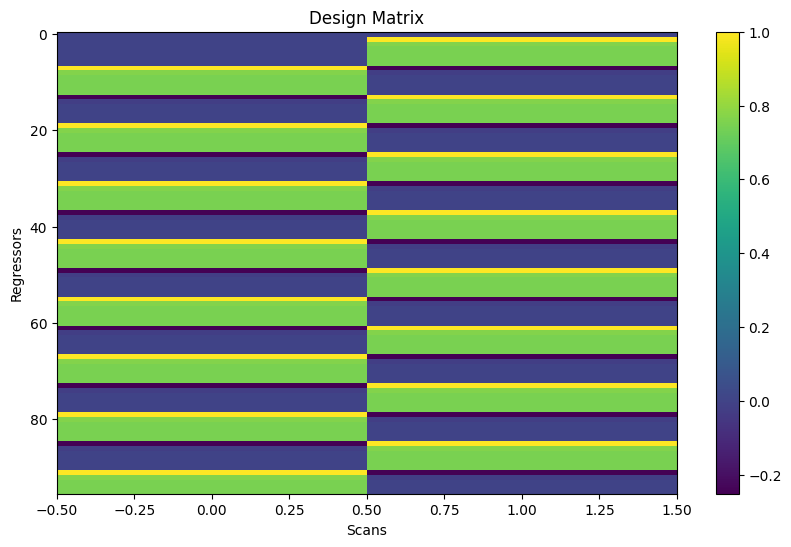

In [192]:
# Plot the design matrix
plt.figure(figsize=(10, 6))
plt.imshow(design_matrix, aspect='auto')
plt.xlabel('Scans')
plt.ylabel('Regressors')
plt.title('Design Matrix')
plt.colorbar()
plt.show()

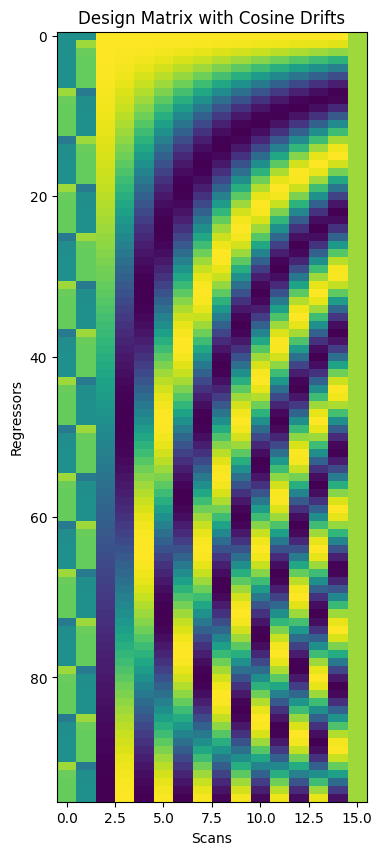

In [198]:
# Assuming 'design_matrix' is already created with your event-related regressors

# Parameters
n_scans = fmri_img.shape[-1]
tr = 7  # Time of repetition in seconds
high_pass = 0.01  # High pass filter cutoff in Hz

# Total scanning time
total_scan_time = n_scans * tr

# Calculate the number of cosine drift terms (rule of thumb: 2x the period of cutoff)
num_cosine_terms = int(np.floor(2 * total_scan_time * high_pass))

# Generate cosine drift terms
for i in range(num_cosine_terms):
    frequency = (1 / total_scan_time) * (i + 1)
    cosine_drift = np.cos(np.arange(n_scans) * 1 * np.pi * frequency * tr)
    design_matrix[f'cosine_drift_{i}'] = cosine_drift

# Orthogonalize (optional)
# Here we orthogonalize cosine drift terms against the other regressors
#other_regressors = design_matrix.columns.difference(['cosine_drift_' + str(i) for i in range(num_cosine_terms)])
#X = design_matrix[other_regressors]
#for i in range(num_cosine_terms):
#    drift_column = f'cosine_drift_{i}'
#    orthogonalized_drift = design_matrix[drift_column] - X.dot(np.linalg.pinv(X).dot(design_matrix[drift_column]))
#    design_matrix[drift_column] = orthogonalized_drift

# Normalize each drift regressor to have unit variance
for i in range(num_cosine_terms):
    drift_column = f'cosine_drift_{i}'
    design_matrix[drift_column] /= np.std(design_matrix[drift_column])

#design_matrix['active'] /= np.std(design_matrix['active']) #/ high_pass
#design_matrix['rest'] /= np.std(design_matrix['rest']) #/ high_pass

# Add a constant term
design_matrix['constant'] = 1

# Plot the design matrix
plt.figure(figsize=(4, 10))
plt.imshow(design_matrix, aspect='auto')
plt.xlabel('Scans')
plt.ylabel('Regressors')
plt.title('Design Matrix with Cosine Drifts')
#plt.colorbar()
plt.show()


In [194]:
design_matrix.iloc[[1,0]]

,active,rest,cosine_drift_0,cosine_drift_1,cosine_drift_2,cosine_drift_3,cosine_drift_4,cosine_drift_5,cosine_drift_6,cosine_drift_7,cosine_drift_8,cosine_drift_9,cosine_drift_10,cosine_drift_11,cosine_drift_12,constant
7,0.0,2.326722,1.413610,1.411186,1.407556,1.402115,1.395476,1.387040,1.377419,1.366025,1.353465,1.339161,1.323714,1.306563,1.288296,1
0,0.0,0.000000,1.414367,1.414214,1.414367,1.414214,1.414367,1.414214,1.414367,1.414214,1.414367,1.414214,1.414367,1.414214,1.414367,1
